<a href="https://colab.research.google.com/github/DanielaDSMS/AN2DL/blob/main/Hipotesis_de_challenge1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 🌐 **Google Drive Connection**

In [1]:
from google.colab import drive
drive.mount("/gdrive")
current_dir = "/gdrive/My\\ Drive/AN2DL/challenge1"
%cd $current_dir

Mounted at /gdrive
[Errno 2] No such file or directory: '/gdrive/My Drive/AN2DL/challenge1'
/content


## ⚙️ **Libraries** **Import**

In [43]:
# Set seed for reproducibility
SEED = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np
from scipy.stats import norm, ttest_ind
from scipy.signal import welch

from sklearn.feature_selection import VarianceThreshold
from sklearn.utils.class_weight import compute_class_weight

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
# from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import TensorDataset, DataLoader
logs_dir = "tensorboard"
!pkill -f tensorboard
%load_ext tensorboard
!mkdir -p models

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import copy
import shutil
from itertools import product
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
PyTorch version: 2.8.0+cu126
Device: cuda


## ⏳ **Data Loading**

In [3]:

# Set environment variables for dataset paths
os.environ["TRAIN_FILE"] = "pirate_pain_train.csv"
os.environ["TRAIN_URL"] = "1yRqrSB1JQwH09p1fXpO7lNfQZBl0PSBs"
os.environ["LABEL_FILE"] = "pirate_pain_train_labels.csv"
os.environ["LABEL_URL"] = "1BhWWiWQeBt9R4BcenRjzuuO0-VKQV8oJ"
os.environ["TEST_FILE"] = "pirate_pain_test.csv"
os.environ["TEST_URL"] = "1fXPfRottySriJF2uyRzpUgOI5affanMa"

# Check if Activity Recognition dataset exists and download if not
if not os.path.exists(os.environ["TRAIN_FILE"]):
    print("Downloading Activity Recognition dataset...")
    !gdown -q ${TRAIN_URL} -O ${TRAIN_FILE}
    print("Activity Recognition dataset1 downloaded!")
else:
    print("Activity Recognition dataset1 already downloaded. Using cached data.")

if not os.path.exists(os.environ["LABEL_FILE"]):
    print("Downloading Activity Recognition dataset...")
    !gdown -q ${LABEL_URL} -O ${LABEL_FILE}
    print("Activity Recognition dataset2 downloaded!")
else:
    print("Activity Recognition dataset2 already downloaded. Using cached data.")

if not os.path.exists(os.environ["TEST_FILE"]):
    print("Downloading Activity Recognition dataset...")
    !gdown -q ${TEST_URL} -O ${TEST_FILE}
    print("Activity Recognition dataset3 downloaded!")
else:
    print("Activity Recognition dataset3 already downloaded. Using cached data.")



Activity Recognition dataset1 downloaded!
Activity Recognition dataset2 downloaded!
Activity Recognition dataset3 downloaded!


## 🔎 **Exploration and Data Analysis**


In [4]:
# Load the dataset from a CSV file
dataset_train = pd.read_csv('pirate_pain_train.csv')
dataset_labels = pd.read_csv('pirate_pain_train_labels.csv')
dataset_test = pd.read_csv('pirate_pain_test.csv')

# Print the shape of the dataset
print(f"Dataset shape: {dataset_train.shape}")
print(f"Dataset shape: {dataset_labels.shape}")

# Display the first few rows of the dataset
dataset_train.head()
#661 is the number of people

Dataset shape: (105760, 40)
Dataset shape: (661, 2)


,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_21,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29,joint_30
0,0,0,2,0,2,1,two,two,two,1.094705,...,3.499558e-06,1.945042e-06,0.000004,1.153299e-05,0.000004,0.017592,0.013508,0.026798,0.027815,0.5
1,0,1,2,2,2,2,two,two,two,1.135183,...,3.976952e-07,6.765107e-07,0.000006,4.643774e-08,0.000000,0.013352,0.000000,0.013377,0.013716,0.5
2,0,2,2,0,2,2,two,two,two,1.080745,...,1.533820e-07,1.698525e-07,0.000001,2.424536e-06,0.000003,0.016225,0.008110,0.024097,0.023105,0.5
3,0,3,2,2,2,2,two,two,two,0.938017,...,1.006865e-05,5.511079e-07,0.000002,5.432416e-08,0.000000,0.011832,0.007450,0.028613,0.024648,0.5
4,0,4,2,2,2,2,two,two,two,1.090185,...,4.437266e-06,1.735459e-07,0.000002,5.825366e-08,0.000007,0.005360,0.002532,0.033026,0.025328,0.5


In [5]:

#Everyone did 160 seconds or 2 min
counts_per_sample = dataset_train.groupby('sample_index')['time'].count()
all_160_timesteps = (counts_per_sample == 160).all()
print(f"All subjects have 160 time steps: {all_160_timesteps}")

All subjects have 160 time steps: True


In [6]:
print(dataset_train.isna().mean().sort_values(ascending=False).head(10))
print(dataset_train['sample_index'].nunique(), dataset_labels['sample_index'].nunique())

sample_index     0.0
time             0.0
pain_survey_1    0.0
pain_survey_2    0.0
pain_survey_3    0.0
pain_survey_4    0.0
n_legs           0.0
n_hands          0.0
n_eyes           0.0
joint_00         0.0
dtype: float64
661 661


- No missing values: All columns show a mean of 0.0 for null values, meaning the dataset is clean and doesn't require imputation or removal of NaNs.

- Subject count consistency: Both dataset_train and dataset_labels contain 661 unique sample_index entries, confirming alignment between features and labels.

dataset_train['sample_index'].nunique() = 661

dataset_labels['sample_index'].nunique() = 661

# Is it balance or imbalance?

In [7]:
dataset_labels['label'].value_counts()

,count
label,
no_pain,511
low_pain,94
high_pain,56


In [8]:
dataset_labels['label'].value_counts(normalize=True)

,proportion
label,
no_pain,0.773071
low_pain,0.142209
high_pain,0.084720


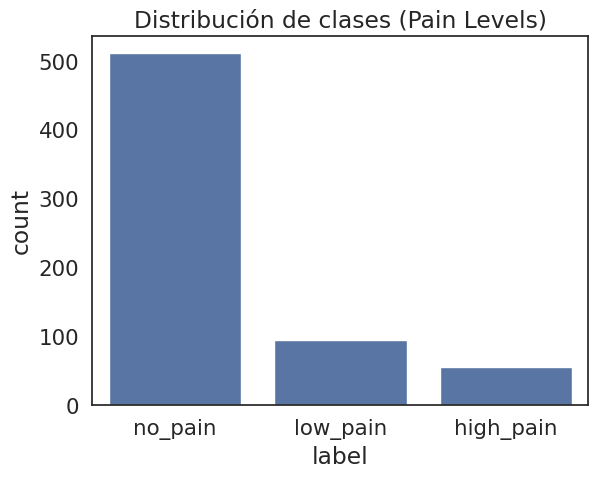

In [9]:
sns.countplot(data=dataset_labels, x='label')
plt.title('Distribución de clases (Pain Levels)')
plt.show()


Result: class imbalance, tend to no_pain

# NOISE


# Step 1: Visual inspection (plots)

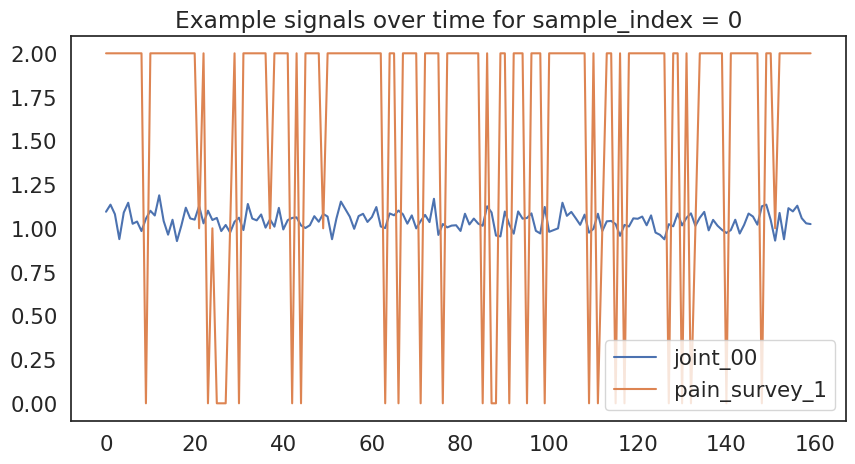

In [10]:
subject = dataset_train[dataset_train['sample_index'] == 0]

plt.figure(figsize=(10,5))
plt.plot(subject['time'], subject['joint_00'], label='joint_00')
plt.plot(subject['time'], subject['pain_survey_1'], label='pain_survey_1')
plt.legend()
plt.title('Example signals over time for sample_index = 0')
plt.show()

Find the kept-up average line,

In [11]:
selector = VarianceThreshold(threshold=1e-5)
selector.fit(dataset_train.select_dtypes(float))

low_var_cols = dataset_train.select_dtypes(float).columns[~selector.get_support()]
print("Low variance features:", low_var_cols.tolist())


Low variance features: ['joint_13', 'joint_14', 'joint_15', 'joint_16', 'joint_23', 'joint_24', 'joint_30']


This lines are to find sensors with unusually large or unstable values.

In [12]:
stats = dataset_train.describe().T
stats['range'] = stats['max'] - stats['min']
stats['std_over_mean'] = stats['std'] / stats['mean'].abs()

stats[['range', 'std_over_mean']].sort_values('std_over_mean', ascending=False).head(10)

,range,std_over_mean
joint_22,1.305001,131.015423
joint_21,1.442198,125.235102
joint_23,0.274241,34.686300
joint_25,0.947354,31.291376
joint_19,0.616061,20.430056
joint_20,1.096014,20.275951
joint_14,0.264232,18.363109
joint_18,0.728382,17.025618
joint_16,0.188807,15.010470
joint_13,0.073852,13.007174


The ones that we need to remove are:

['joint_13','joint_14', 'joint_15','joint_16','joint_18','joint_19','joint_20',
  'joint_21','joint_22','joint_23','joint_24','joint_25','joint_30']

# Class imbalance Solution

In [13]:
classes = np.unique(dataset_labels['label'])
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=dataset_labels['label']
)
class_weights = dict(zip(classes, class_weights))
print(class_weights)


{'high_pain': np.float64(3.9345238095238093), 'low_pain': np.float64(2.3439716312056738), 'no_pain': np.float64(0.43118069145466403)}


So then in the model training you use this:

class_weights_tensor = torch.tensor([class_weights[c] for c in classes], dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)



# Remove unnecessary or noisy features


In [14]:
# List of noisy / unnecessary features
noisy_features = [
    'joint_13', 'joint_14', 'joint_15', 'joint_16',
    'joint_18', 'joint_19', 'joint_20', 'joint_21',
    'joint_22', 'joint_23', 'joint_24', 'joint_25', 'joint_30'
]

# Remove them off the dataset
dataset_train_clean = dataset_train.drop(columns=[c for c in noisy_features if c in dataset_train.columns], errors='ignore')
dataset_test_clean  = dataset_test.drop(columns=[c for c in noisy_features if c in dataset_test.columns], errors='ignore')

print("✅ Removed noisy features.")
print(f"Original dataset_train shape: {dataset_train.shape}")
print(f"Cleaned  dataset_train shape: {dataset_train_clean.shape}")
print(f"Original dataset_test shape:  {dataset_test.shape}")
print(f"Cleaned  dataset_test shape:  {dataset_test_clean.shape}")


✅ Removed noisy features.
Original dataset_train shape: (105760, 40)
Cleaned  dataset_train shape: (105760, 27)
Original dataset_test shape:  (211840, 40)
Cleaned  dataset_test shape:  (211840, 27)


Create NEW datasets with "disability" column and also drop the previous (3) separate ones.

In [31]:
# NEW copies of train and test sets with disability column
dataset_train_with_disability = dataset_train_clean.copy()
dataset_test_with_disability = dataset_test_clean.copy()

# Anything non-two (eyes, hands, legs)
def is_disabled(value): return value != 'two'

# Every row checks across n_legs, n_hands, n_eyes
dataset_train_with_disability['disability'] = dataset_train_with_disability[['n_legs', 'n_hands', 'n_eyes']].apply(
    lambda row: any(is_disabled(v) for v in row), axis=1 ).astype(int)

dataset_test_with_disability['disability'] = dataset_test_with_disability[['n_legs', 'n_hands', 'n_eyes']].apply(
    lambda row: any(is_disabled(v) for v in row), axis=1 ).astype(int)

    # Convert it to float before training?

# Drop the old columns
dataset_train_with_disability = dataset_train_with_disability.drop(columns=['n_legs', 'n_hands', 'n_eyes'])
dataset_test_with_disability = dataset_test_with_disability.drop(columns=['n_legs', 'n_hands', 'n_eyes'])

Display new disability set changes:

In [16]:
print("Original columns:", dataset_train_clean.columns[:10])
print("New columns:", dataset_train_with_disability.columns[:10])
print("Number of disabled subjects entries:", dataset_train_with_disability['disability'].sum())
disabled_subjects = dataset_train_with_disability.groupby('sample_index')['disability'].max().sum()
print("Number of unique disabled subjects:", disabled_subjects)
print("Disabled subjects are this percentage (%) of the total subjects:", disabled_subjects/dataset_train['sample_index'].nunique()*100)
dataset_train_with_disability.head() # Disability column at the end

Original columns: Index(['sample_index', 'time', 'pain_survey_1', 'pain_survey_2',
       'pain_survey_3', 'pain_survey_4', 'n_legs', 'n_hands', 'n_eyes',
       'joint_00'],
      dtype='object')
New columns: Index(['sample_index', 'time', 'pain_survey_1', 'pain_survey_2',
       'pain_survey_3', 'pain_survey_4', 'joint_00', 'joint_01', 'joint_02',
       'joint_03'],
      dtype='object')
Number of disabled subjects entries: 960
Number of unique disabled subjects: 6
Disabled subjects are this percentage (%) of the total subjects: 0.9077155824508321


,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,joint_00,joint_01,joint_02,joint_03,...,joint_09,joint_10,joint_11,joint_12,joint_17,joint_26,joint_27,joint_28,joint_29,disability
0,0,0,2,0,2,1,1.094705,0.985281,1.018302,1.010385,...,1.050142,0.529555,0.447370,1.091046,0.000000,0.017592,0.013508,0.026798,0.027815,0
1,0,1,2,2,2,2,1.135183,1.021175,0.994343,1.052364,...,1.060313,0.446810,0.414432,1.045862,0.000009,0.013352,0.000000,0.013377,0.013716,0
2,0,2,2,0,2,2,1.080745,0.962842,1.009588,0.977169,...,1.011410,0.432499,0.431535,1.088221,0.000000,0.016225,0.008110,0.024097,0.023105,0
3,0,3,2,2,2,2,0.938017,1.081592,0.998021,0.987283,...,1.047223,0.478806,0.420665,1.096832,0.000035,0.011832,0.007450,0.028613,0.024648,0
4,0,4,2,2,2,2,1.090185,1.032145,1.008710,0.963658,...,1.044731,0.452906,0.476537,1.103968,0.000000,0.005360,0.002532,0.033026,0.025328,0


Normalize the disability set with 0 mean and 1 standard deviation. Including time!

In [17]:
from sklearn.preprocessing import StandardScaler
scaler_disability = StandardScaler()

# Only numeric columns ("disability acts as a boolean -> does not count") Normalizing time!
numeric_columns_disability = [v for v in dataset_train_with_disability.columns
                           if v not in ['sample_index', 'disability']]

# Fitted on training set only
scaler_disability.fit(dataset_train_with_disability[numeric_columns_disability])

# Transform both training and testing sets
dataset_train_with_disability_normalized = dataset_train_with_disability.copy()
dataset_test_with_disability_normalized = dataset_test_with_disability.copy()

dataset_train_with_disability_normalized[numeric_columns_disability] = scaler_disability.transform(
    dataset_train_with_disability[numeric_columns_disability] )
dataset_test_with_disability_normalized[numeric_columns_disability] = scaler_disability.transform(
    dataset_test_with_disability[numeric_columns_disability] )

Normalize the clear set with 0 mean and 1 standard deviation. **Ignoring** the string columns n_eyes, ...
Including time!

In [18]:
scaler_clean = StandardScaler()

# Numeric columns to normalize (exclude sample_index)   Normalizing time!
numeric_columns_clean = [c for c in dataset_train_clean.select_dtypes(include=['float64', 'int64']).columns
                         if c != 'sample_index']

# Fitted on training set only
scaler_clean.fit(dataset_train_clean[numeric_columns_clean])

# Transform both training and testing sets
dataset_train_clean_normalized = dataset_train_clean.copy()
dataset_test_clean_normalized  = dataset_test_clean.copy()

dataset_train_clean_normalized[numeric_columns_clean] = scaler_clean.transform(
    dataset_train_clean[numeric_columns_clean])
dataset_test_clean_normalized[numeric_columns_clean] = scaler_clean.transform(
    dataset_test_clean[numeric_columns_clean])

In [19]:
# Verify disability set normalization
print("-------------------------------------------------------Disability set\n")
print("Normalized numeric columns:", numeric_columns_disability)
print("Total normalized columns:", len(numeric_columns_disability))

# Before normalization
print("\nBefore normalization (train):")
print(dataset_train_clean[numeric_columns_disability].describe().loc[['mean', 'std']])

# After normalization
print("\nAfter normalization (train):")
print(dataset_train_clean_normalized[numeric_columns_disability].describe().loc[['mean', 'std']])

# Sample of normalized dataset
print("\nSample of normalized train dataset:")
print(dataset_train_with_disability_normalized.head(3))


# Verifiy clean set normalization
print("\n--------------------------------------------------- Clean set\n")
print("Normalized numeric columns:", numeric_columns_clean)
print("Total normalized columns:", len(numeric_columns_clean))

# Before normalization
print("\nBefore normalization (train):")
print(dataset_train_clean[numeric_columns_clean].describe().loc[['mean', 'std']])

# After normalization
print("\nAfter normalization (train):")
print(dataset_train_clean_normalized[numeric_columns_clean].describe().loc[['mean', 'std']])

# Categorical columns untouched
categorical_columns = dataset_train_clean.select_dtypes(include=['object']).columns
print("\nCategorical columns (unchanged):", list(categorical_columns))
print(dataset_train_clean_normalized[categorical_columns].head(3))

# Sample of normalized dataset
print("\nSample of normalized train dataset:")
print(dataset_train_clean_normalized.head(3))

-------------------------------------------------------Disability set

Normalized numeric columns: ['time', 'pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4', 'joint_00', 'joint_01', 'joint_02', 'joint_03', 'joint_04', 'joint_05', 'joint_06', 'joint_07', 'joint_08', 'joint_09', 'joint_10', 'joint_11', 'joint_12', 'joint_17', 'joint_26', 'joint_27', 'joint_28', 'joint_29']
Total normalized columns: 23

Before normalization (train):
           time  pain_survey_1  pain_survey_2  pain_survey_3  pain_survey_4  \
mean  79.500000       1.633746       1.654851       1.653640       1.663134   
std   46.187338       0.682423       0.669639       0.666649       0.661994   

      joint_00  joint_01  joint_02  joint_03  joint_04  ...  joint_08  \
mean  0.943095  0.916955  0.779296  0.767921  0.709186  ...  0.849700   
std   0.202051  0.197608  0.295605  0.300787  0.418058  ...  0.180489   

      joint_09  joint_10  joint_11  joint_12  joint_17  joint_26  joint_27  \
mean  0.9095

Valores únicos de label: ['no_pain' 'low_pain' 'high_pain']
✅ 'disability' ya existe en dataset_train_with_disability
Articulaciones detectadas: 18
Ejemplo sin dolor: 0 | Ejemplo con dolor alto: 37


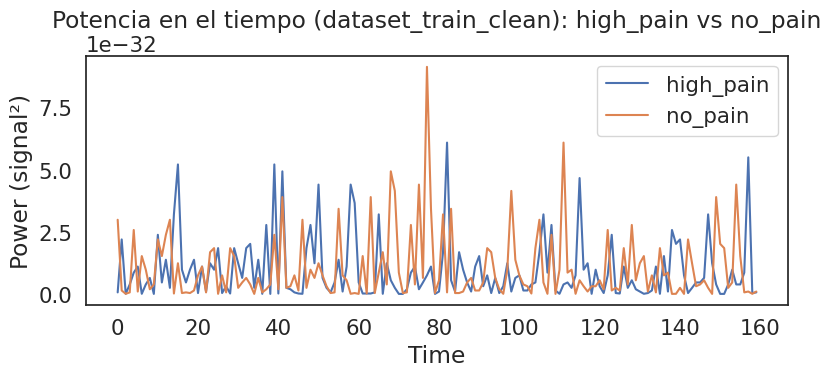

Frecuencia de muestreo estimada a partir de 'time': 100.00 Hz


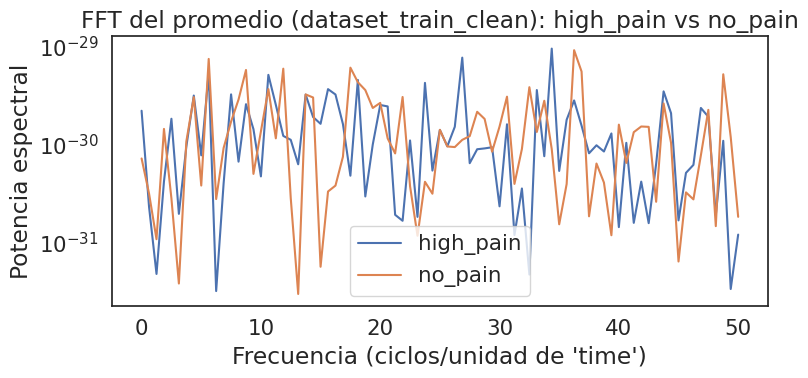

In [28]:

# 1) Combinar datos limpios (el que tiene la de disability) con las etiquetas
df = dataset_train_with_disability.merge(dataset_labels, on='sample_index', how='left')

print("Valores únicos de label:", df['label'].unique())

joint_cols = [c for c in df.columns if c.startswith('joint_')] #joints used

# 2) Elegir un ejemplo no_pain y uno high_pain
no_pain_id   = df[df['label'] == 'no_pain']['sample_index'].iloc[0]
high_pain_id = df[df['label'] == 'high_pain']['sample_index'].iloc[0]

print(f"Ejemplo sin dolor: {no_pain_id} | Ejemplo con dolor alto: {high_pain_id}")

no_pain_df   = df[df['sample_index'] == no_pain_id].sort_values('time')
high_pain_df = df[df['sample_index'] == high_pain_id].sort_values('time')

# 3) Señal promedio entre canales + potencia
X_nopain   = no_pain_df[joint_cols].values
X_highpain = high_pain_df[joint_cols].values

X_nopain_ref   = X_nopain - X_nopain.mean(axis=1, keepdims=True)
X_highpain_ref = X_highpain - X_highpain.mean(axis=1, keepdims=True)

sig_nopain   = X_nopain_ref.mean(axis=1)
sig_highpain = X_highpain_ref.mean(axis=1)

power_nopain   = sig_nopain**2
power_highpain = sig_highpain**2

t_nopain   = no_pain_df['time'].values
t_highpain = high_pain_df['time'].values

plt.figure(figsize=(8,4))
plt.plot(t_highpain, power_highpain, label='high_pain')
plt.plot(t_nopain,  power_nopain,  label='no_pain')
plt.xlabel("Time")
plt.ylabel("Power (signal²)")
plt.title("Potencia en el tiempo (dataset_train_clean): high_pain vs no_pain")
plt.legend()
plt.tight_layout()
plt.show()

# 4) FFT del promedio
def fft_power(x, fs):
    n = len(x)
    fft_vals = np.fft.rfft(x)
    freqs = np.fft.rfftfreq(n, d=1.0/fs)
    power_spec = np.abs(fft_vals)**2
    return freqs, power_spec

dt = np.diff(t_highpain).mean()
fs = 100.0 / dt
print(f"Frecuencia de muestreo estimada a partir de 'time': {fs:.2f} Hz")

freqs_high, Pspec_high = fft_power(sig_highpain, fs)
freqs_no,   Pspec_no   = fft_power(sig_nopain,  fs)

plt.figure(figsize=(8,4))
plt.semilogy(freqs_high, Pspec_high, label='high_pain')
plt.semilogy(freqs_no,   Pspec_no,   label='no_pain')
plt.xlabel("Frecuencia (ciclos/unidad de 'time')")
plt.ylabel("Potencia espectral")
plt.title("FFT del promedio (dataset_train_clean): high_pain vs no_pain")
plt.legend()
plt.tight_layout()
plt.show()


Columnas dataset_train: ['sample_index', 'time', 'pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4', 'n_legs', 'n_hands', 'n_eyes', 'joint_00', 'joint_01', 'joint_02', 'joint_03', 'joint_04', 'joint_05', 'joint_06', 'joint_07', 'joint_08', 'joint_09', 'joint_10', 'joint_11', 'joint_12', 'joint_13', 'joint_14', 'joint_15', 'joint_16', 'joint_17', 'joint_18', 'joint_19', 'joint_20', 'joint_21', 'joint_22', 'joint_23', 'joint_24', 'joint_25', 'joint_26', 'joint_27', 'joint_28', 'joint_29', 'joint_30']
Valores únicos de label: ['no_pain' 'low_pain' 'high_pain']
is_pain
False    81760
True     24000
Name: count, dtype: int64
Sample no_pain: 0, sample pain: 2
Articulaciones detectadas: 31 ['joint_00', 'joint_01', 'joint_02', 'joint_03', 'joint_04', 'joint_05', 'joint_06', 'joint_07', 'joint_08', 'joint_09', 'joint_10', 'joint_11', 'joint_12', 'joint_13', 'joint_14', 'joint_15', 'joint_16', 'joint_17', 'joint_18', 'joint_19', 'joint_20', 'joint_21', 'joint_22', 'joint_23', 'jo

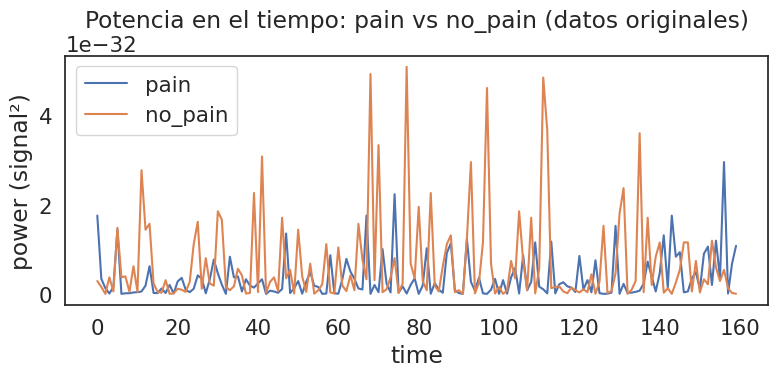

Frecuencia de muestreo estimada: 1.00 Hz


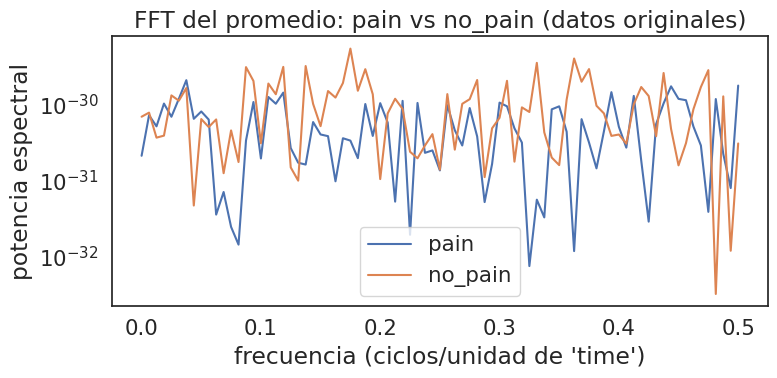

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# 0) Partimos de lo que YA tienes
# =========================
# dataset_train = pd.read_csv('pirate_pain_train.csv')
# dataset_labels = pd.read_csv('pirate_pain_train_labels.csv')

print("Columnas dataset_train:", dataset_train.columns.tolist())
print("Valores únicos de label:", dataset_labels['label'].unique())

# =========================
# 1) Unir datos originales + labels
# =========================
df = dataset_train.merge(dataset_labels, on='sample_index', how='left')

# Crear columna binaria: no_pain vs pain (low_pain + high_pain)
df['is_pain'] = df['label'] != 'no_pain'

print(df['is_pain'].value_counts())  # cuántas muestras de cada tipo

# =========================
# 2) Elegir UN sample no_pain y UN sample pain
# =========================
no_pain_id = df[df['is_pain'] == False]['sample_index'].iloc[0]
pain_id    = df[df['is_pain'] == True]['sample_index'].iloc[0]

print(f"Sample no_pain: {no_pain_id}, sample pain: {pain_id}")

no_pain_df = df[df['sample_index'] == no_pain_id].sort_values('time')
pain_df    = df[df['sample_index'] == pain_id].sort_values('time')

# =========================
# 3) Sacar solo las articulaciones (joints) de los datos ORIGINALES
# =========================
joint_cols = [c for c in df.columns if c.startswith('joint_')]
print("Articulaciones detectadas:", len(joint_cols), joint_cols)

X_no  = no_pain_df[joint_cols].values  # [tiempo, canales]
X_yes = pain_df[joint_cols].values

# =========================
# 4) Promedio entre canales + potencia en el tiempo
# =========================

# Referencia promedio (restar media entre canales en cada instante)
X_no_ref  = X_no  - X_no.mean(axis=1, keepdims=True)
X_yes_ref = X_yes - X_yes.mean(axis=1, keepdims=True)

# Señal promedio entre canales
sig_no  = X_no_ref.mean(axis=1)
sig_yes = X_yes_ref.mean(axis=1)

# Potencia instantánea
power_no  = sig_no**2
power_yes = sig_yes**2

t_no  = no_pain_df['time'].values
t_yes = pain_df['time'].values

plt.figure(figsize=(8,4))
plt.plot(t_yes, power_yes, label='pain')
plt.plot(t_no,  power_no,  label='no_pain')
plt.xlabel("time")
plt.ylabel("power (signal²)")
plt.title("Potencia en el tiempo: pain vs no_pain (datos originales)")
plt.legend()
plt.tight_layout()
plt.show()

# =========================
# 5) FFT de la señal promedio (tal cual, sin bandas raras)
# =========================
def fft_power(x, fs):
    n = len(x)
    fft_vals = np.fft.rfft(x)
    freqs = np.fft.rfftfreq(n, d=1.0/fs)
    power_spec = np.abs(fft_vals)**2
    return freqs, power_spec

# Frecuencia de muestreo según 'time'
dt = np.diff(t_yes).mean()
fs = 1.0 / dt
print(f"Frecuencia de muestreo estimada: {fs:.2f} Hz")

freqs_yes, P_yes = fft_power(sig_yes, fs)
freqs_no,  P_no  = fft_power(sig_no,  fs)

plt.figure(figsize=(8,4))
plt.semilogy(freqs_yes, P_yes, label='pain')
plt.semilogy(freqs_no,  P_no,  label='no_pain')
plt.xlabel("frecuencia (ciclos/unidad de 'time')")
plt.ylabel("potencia espectral")
plt.title("FFT del promedio: pain vs no_pain (datos originales)")
plt.legend()
plt.tight_layout()
plt.show()


         count          mean           std           min           25%  \
is_pain                                                                  
False    511.0  6.017884e-33  2.014334e-33  1.152772e-33  5.398123e-33   
True     150.0  6.565835e-33  1.302642e-33  2.393724e-33  5.861829e-33   

                  50%           75%           max  
is_pain                                            
False    6.568909e-33  7.358435e-33  1.025555e-32  
True     6.710516e-33  7.444409e-33  9.452769e-33  


<Figure size 500x400 with 0 Axes>

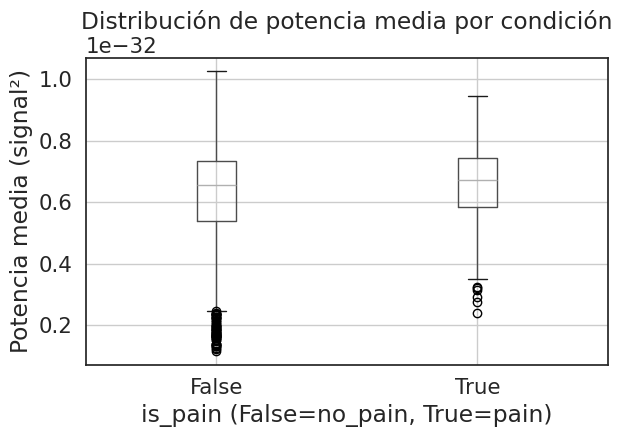

In [30]:
# Calcular potencia media por muestra
joint_cols = [c for c in dataset_train.columns if c.startswith('joint_')]

powers = []
for sid, group in df.groupby('sample_index'):
    X = group[joint_cols].values
    X_ref = X - X.mean(axis=1, keepdims=True)
    sig = X_ref.mean(axis=1)
    power = np.mean(sig**2)
    label = group['is_pain'].iloc[0]
    powers.append((sid, label, power))

power_df = pd.DataFrame(powers, columns=['sample_index', 'is_pain', 'mean_power'])

print(power_df.groupby('is_pain')['mean_power'].describe())

# Boxplot para comparar distribuciones
plt.figure(figsize=(5,4))
power_df.boxplot(column='mean_power', by='is_pain')
plt.title("Distribución de potencia media por condición")
plt.suptitle("")
plt.xlabel("is_pain (False=no_pain, True=pain)")
plt.ylabel("Potencia media (signal²)")
plt.tight_layout()
plt.show()


is_it_pain
False    81760
True     24000
Name: count, dtype: int64
Sample no_pain: 0, sample pain: 2
Articulaciones detectadas: 18 ['joint_00', 'joint_01', 'joint_02', 'joint_03', 'joint_04', 'joint_05', 'joint_06', 'joint_07', 'joint_08', 'joint_09', 'joint_10', 'joint_11', 'joint_12', 'joint_17', 'joint_26', 'joint_27', 'joint_28', 'joint_29']


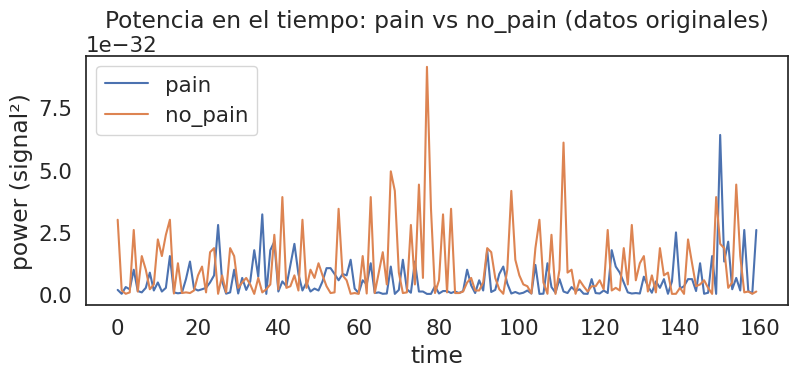

Frecuencia de muestreo estimada: 1.00 Hz


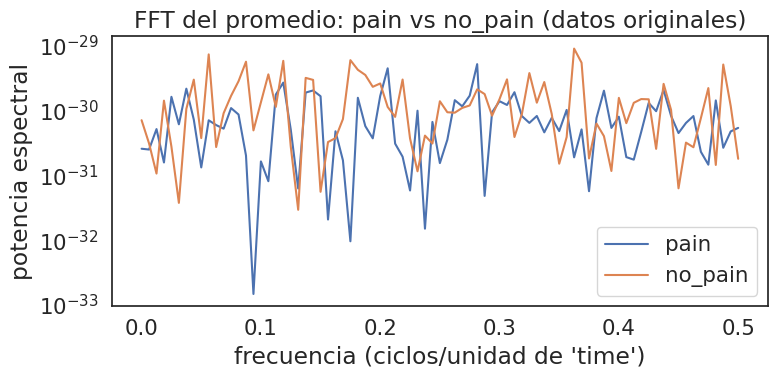

In [35]:
#compare the labels with the data on train
df1 = dataset_train_with_disability.merge(dataset_labels, on='sample_index', how='left')

# Crear columna binaria: no_pain vs pain (si es pain = low + high) (distinti de no pain = pain)
df1['is_it_pain'] = df1['label'] != 'no_pain'

print(df1['is_it_pain'].value_counts())  # cuántas muestras de cada tipo


# 2) Elegir UN sample no_pain y UN sample pain
no_pain_id1 = df1[df1['is_it_pain'] == False]['sample_index'].iloc[0]
pain_id1    = df1[df1['is_it_pain'] == True]['sample_index'].iloc[0]

print(f"Sample no_pain: {no_pain_id1}, sample pain: {pain_id1}")

no_pain_df1 = df1[df1['sample_index'] == no_pain_id1].sort_values('time')
pain_df1    = df1[df1['sample_index'] == pain_id1].sort_values('time')


# 3) Sacar solo las articulaciones joints
joint_cols1 = [c for c in df1.columns if c.startswith('joint_')]
print("Articulaciones detectadas:", len(joint_cols1), joint_cols1)

X_no1  = no_pain_df1[joint_cols1].values  # [tiempo, canales]
X_yes1 = pain_df1[joint_cols1].values

# 4) Promedio entre canales + power? en el tiempo
# Referencia promedio (restar media entre canales en cada instante)
X_no_ref1  = X_no1  - X_no1.mean(axis=1, keepdims=True)
X_yes_ref1 = X_yes1 - X_yes1.mean(axis=1, keepdims=True)

# Señal promedio entre canales
sig_no1  = X_no_ref1.mean(axis=1)
sig_yes1 = X_yes_ref1.mean(axis=1)

# Potencia instantánea
power_no1  = sig_no1**2
power_yes1 = sig_yes1**2

t_no1  = no_pain_df1['time'].values
t_yes1 = pain_df1['time'].values

plt.figure(figsize=(8,4))
plt.plot(t_yes1, power_yes1, label='pain')
plt.plot(t_no1,  power_no1,  label='no_pain')
plt.xlabel("time")
plt.ylabel("power (signal²)")
plt.title("Potencia en el tiempo: pain vs no_pain (datos originales)")
plt.legend()
plt.tight_layout()
plt.show()

# 5) FFT de la señal promedio

def fft_power(x, fs):
    n = len(x)
    fft_vals = np.fft.rfft(x)
    freqs = np.fft.rfftfreq(n, d=1.0/fs)
    power_spec = np.abs(fft_vals)**2
    return freqs, power_spec

# Frecuencia de muestreo según 'time'
dt = np.diff(t_yes1).mean()
fs = 1.0 / dt
print(f"Frecuencia de muestreo estimada: {fs:.2f} Hz")

freqs_yes1, P_yes1 = fft_power(sig_yes1, fs)
freqs_no1,  P_no1  = fft_power(sig_no1,  fs)

plt.figure(figsize=(8,4))
plt.semilogy(freqs_yes1, P_yes1, label='pain')
plt.semilogy(freqs_no1,  P_no1,  label='no_pain')
plt.xlabel("frecuencia (ciclos/unidad de 'time')")
plt.ylabel("potencia espectral")
plt.title("FFT del promedio: pain vs no_pain (datos originales)")
plt.legend()
plt.tight_layout()
plt.show()

Number of samples per condition (is_pain):
is_pain
False    81760
True     24000
Name: count, dtype: int64
Example no_pain sample_index: 0, example pain sample_index: 2


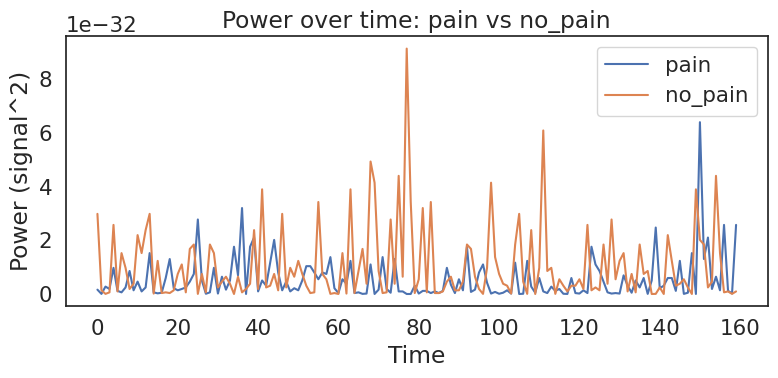

Estimated sampling frequency: 1.00 Hz


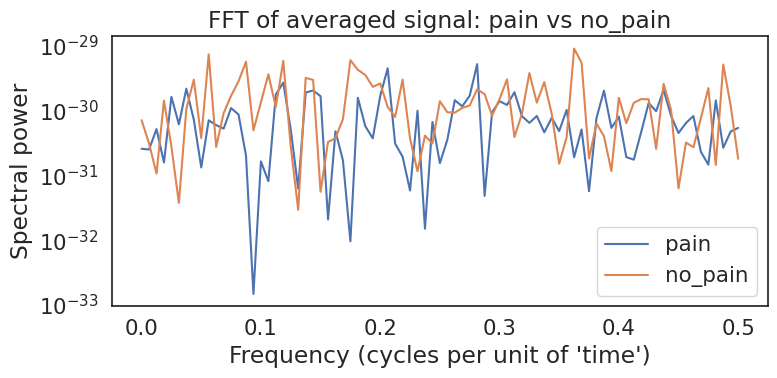


Mean power statistics by condition (is_pain):
         count          mean           std           min           25%  \
is_pain                                                                  
False    511.0  8.808211e-33  3.289544e-33  1.767695e-33  6.850158e-33   
True     150.0  9.394496e-33  2.105029e-33  3.438736e-33  8.400042e-33   

                  50%           75%           max  
is_pain                                            
False    9.963478e-33  1.118659e-32  1.565133e-32  
True     9.724430e-33  1.074831e-32  1.421003e-32  


<Figure size 500x400 with 0 Axes>

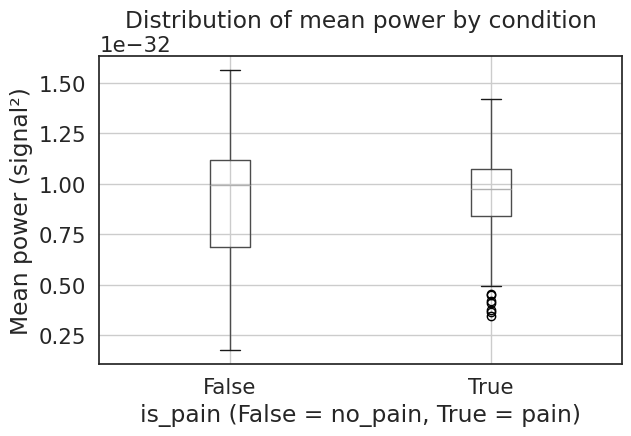

t = 2.6033, p = 9.5920e-03
is_pain
False    8.808211e-33
True     9.394496e-33
Name: mean_power, dtype: float64


In [44]:
# 1) Merge train data (with disability) and labels
df = dataset_train_with_disability.merge(dataset_labels, on='sample_index', how='left')

# Create binary column: no_pain vs pain (low_pain + high_pain)
df['is_pain'] = df['label'] != 'no_pain'

print("Number of samples per condition (is_pain):")
print(df['is_pain'].value_counts())

# 2) take ONE no_pain sample and ONE pain sample (just for visualization)
no_pain_id = df[df['is_pain'] == False]['sample_index'].iloc[0]
pain_id    = df[df['is_pain'] == True]['sample_index'].iloc[0]

print(f"Example no_pain sample_index: {no_pain_id}, example pain sample_index: {pain_id}")

#so just to confirm 0 is labeled as no pain (is_pain == False) and Sample with 2 is labeled as pain (is_pain == True)

no_pain_df = df[df['sample_index'] == no_pain_id].sort_values('time')
pain_df    = df[df['sample_index'] == pain_id].sort_values('time')

# 3) Extract joint columns
joint_cols = [c for c in df.columns if c.startswith('joint_')]
X_no  = no_pain_df[joint_cols].values   # [time, channels]
X_yes = pain_df[joint_cols].values

#print(f"see {X_no}")to show [time, channels]

# 4) Average reference across channels + power over time
# Subtract mean across channels at each time point (average reference)
X_no_ref  = X_no  - X_no.mean(axis=1, keepdims=True)
X_yes_ref = X_yes - X_yes.mean(axis=1, keepdims=True)

# Average signal across channels
sig_no  = X_no_ref.mean(axis=1)
sig_yes = X_yes_ref.mean(axis=1)

#  power ?
power_no  = sig_no**2
power_yes = sig_yes**2

t_no  = no_pain_df['time'].values
t_yes = pain_df['time'].values

plt.figure(figsize=(8, 4))
plt.plot(t_yes, power_yes, label='pain')
plt.plot(t_no,  power_no,  label='no_pain')
plt.xlabel("Time")
plt.ylabel("Power (signal^2)")
plt.title("Power over time: pain vs no_pain")
plt.legend()
plt.tight_layout()
plt.show()

# 5) FFT of the averaged signal
def fft_power(x, fs):
    n = len(x)
    fft_vals = np.fft.rfft(x)
    freqs = np.fft.rfftfreq(n, d=1.0/fs)
    power_spec = np.abs(fft_vals)**2
    return freqs, power_spec

# Sampling frequency estimated from 'time'
dt = np.diff(t_yes).mean()
fs = 1.0 / dt #not so sure about this fs
print(f"Estimated sampling frequency: {fs:.2f} Hz")

freqs_yes, P_yes = fft_power(sig_yes, fs)
freqs_no,  P_no  = fft_power(sig_no,  fs)

plt.figure(figsize=(8, 4))
plt.semilogy(freqs_yes, P_yes, label='pain')
plt.semilogy(freqs_no,  P_no,  label='no_pain')
plt.xlabel("Frequency (cycles per unit of 'time')")
plt.ylabel("Spectral power")
plt.title("FFT of averaged signal: pain vs no_pain")
plt.legend()
plt.tight_layout()
plt.show()

# 6) Mean power per sample_index for the whole dataset
powers = []
for sid, group in df.groupby('sample_index'):
    X = group[joint_cols].values
    X_ref = X - X.mean(axis=1, keepdims=True)
    sig = X_ref.mean(axis=1)
    power = np.mean(sig**2)
    is_pain = group['is_pain'].iloc[0]
    powers.append((sid, is_pain, power))

power_df = pd.DataFrame(powers, columns=['sample_index', 'is_pain', 'mean_power'])

print("\nMean power statistics by condition (is_pain):")
print(power_df.groupby('is_pain')['mean_power'].describe())

# Boxplot to compare distributions
plt.figure(figsize=(5, 4))
power_df.boxplot(column='mean_power', by='is_pain')
plt.title("Distribution of mean power by condition")
plt.suptitle("")
plt.xlabel("is_pain (False = no_pain, True = pain)")
plt.ylabel("Mean power (signal²)")
plt.tight_layout()
plt.show()



pain_vals   = power_df[power_df['is_pain'] == True]['mean_power']
nopain_vals = power_df[power_df['is_pain'] == False]['mean_power']

stat, pval = ttest_ind(pain_vals, nopain_vals, equal_var=False)
print(f"t = {stat:.4f}, p = {pval:.4e}")
print(power_df.groupby('is_pain')['mean_power'].mean())

We compared the mean signal power between pain and no_pain conditions.
If the mean power of pain samples is higher, it indicates that signal energy increases with pain;
if it is lower, it would mean the opposite.

After computing the power using Welch’s method and performing a two-sample t-test, we obtained:
t = 2.6033, p = 0.0096.
Since p < 0.05, the difference is statistically significant, meaning it is very unlikely to be due to random variation.

The mean power values were:

no_pain: 8.81 × 10⁻³³

pain: 9.39 × 10⁻³³

Therefore, the pain condition shows a slightly higher mean signal power than no_pain.
Although the difference is small, it is statistically significant and consistent with the biomedical hypothesis that pain is associated with increased signal energy or activity.